## This script is that same as the pre_process_V1.py for SEEG1.
### 100 setences.

### The channels were selected by removing the bad channels (visual checking). Better way is to just read the channel names from the recon.ppt file and discard the rest, as demonstrated in SEEG2.


In [1]:
import calendar
import datetime
import glob
from utils.util_MNE import delete_annotation, keep_annotation
from dSPEECH.config import *
#plott=False

2024-07-12 12:20:07 - Start Program

pre_all: Running from CMD.


In [2]:
a=5

In [2]:
sf=1024
type='SEEG' #'SEEG/ECoG
sid=1 # SEEG 1/2
eeg_file=data_dir+'raw/'+type+str(sid)+'_*/EEG.edf' # SEEG1_datetime
eeg_file=os.path.normpath(glob.glob(eeg_file)[0])
raw = mne.io.read_raw_edf(eeg_file,preload=True)

In [3]:
raw.plot()

![](img1.png)

### mark the bad channels by simply clicking the channel names in the raw.plot() window.

In [6]:
bad_channels = raw.info['bads'] # 138

In [4]:
# c##/DC#/TRIG/OSAT/PR/Pleth/ECG  + TB-9/HP-6/Ox-10
bad_channels=['C14','C13', 'C16', 'C15', 'C29', 'C30', 'C31', 'C32', 'C46', 'C45', 'C47', 'C48', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C93', 'C95', 'C94', 'C96', 'C109', 'C110', 'C111', 'C112', 'C125', 'C126', 'C144', 'C155', 'C157', 'C156', 'C158', 'C159', 'C160', 'C176', 'C177', 'C178', 'C179', 'C180', 'C181', 'C182', 'C183', 'C184', 'C185', 'C186', 'C187', 'C188', 'C189', 'C190', 'C191', 'C192', 'C193', 'C194', 'C196', 'C195', 'C197', 'C198', 'C200', 'C199', 'C201', 'C202', 'C203', 'C204', 'C205', 'C206', 'C207', 'C208', 'C209', 'C210', 'C211', 'C212', 'C213', 'C214', 'C216', 'C215', 'C217', 'C218', 'C219', 'C220', 'C221', 'C222', 'C223', 'C224', 'C225', 'C226', 'C227', 'C228', 'C229', 'C230', 'C231', 'C232', 'C233', 'C234', 'C235', 'C236', 'C237', 'C238', 'C239', 'C240', 'C241', 'C242', 'C243', 'C244', 'C245', 'C247', 'C246', 'C248', 'C249', 'C250', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC15', 'DC14', 'DC16', 'TRIG', 'OSAT', 'PR','Pleth']

In [4]:
len(bad_channels)

138

In [5]:
raw.drop_channels(bad_channels)  # 276--> 138

<RawEDF | EEG.edf, 138 x 4353024 (4251.0 s), ~4.48 GB, data loaded>

### Now look at the PSD profile to further check the bad channels.

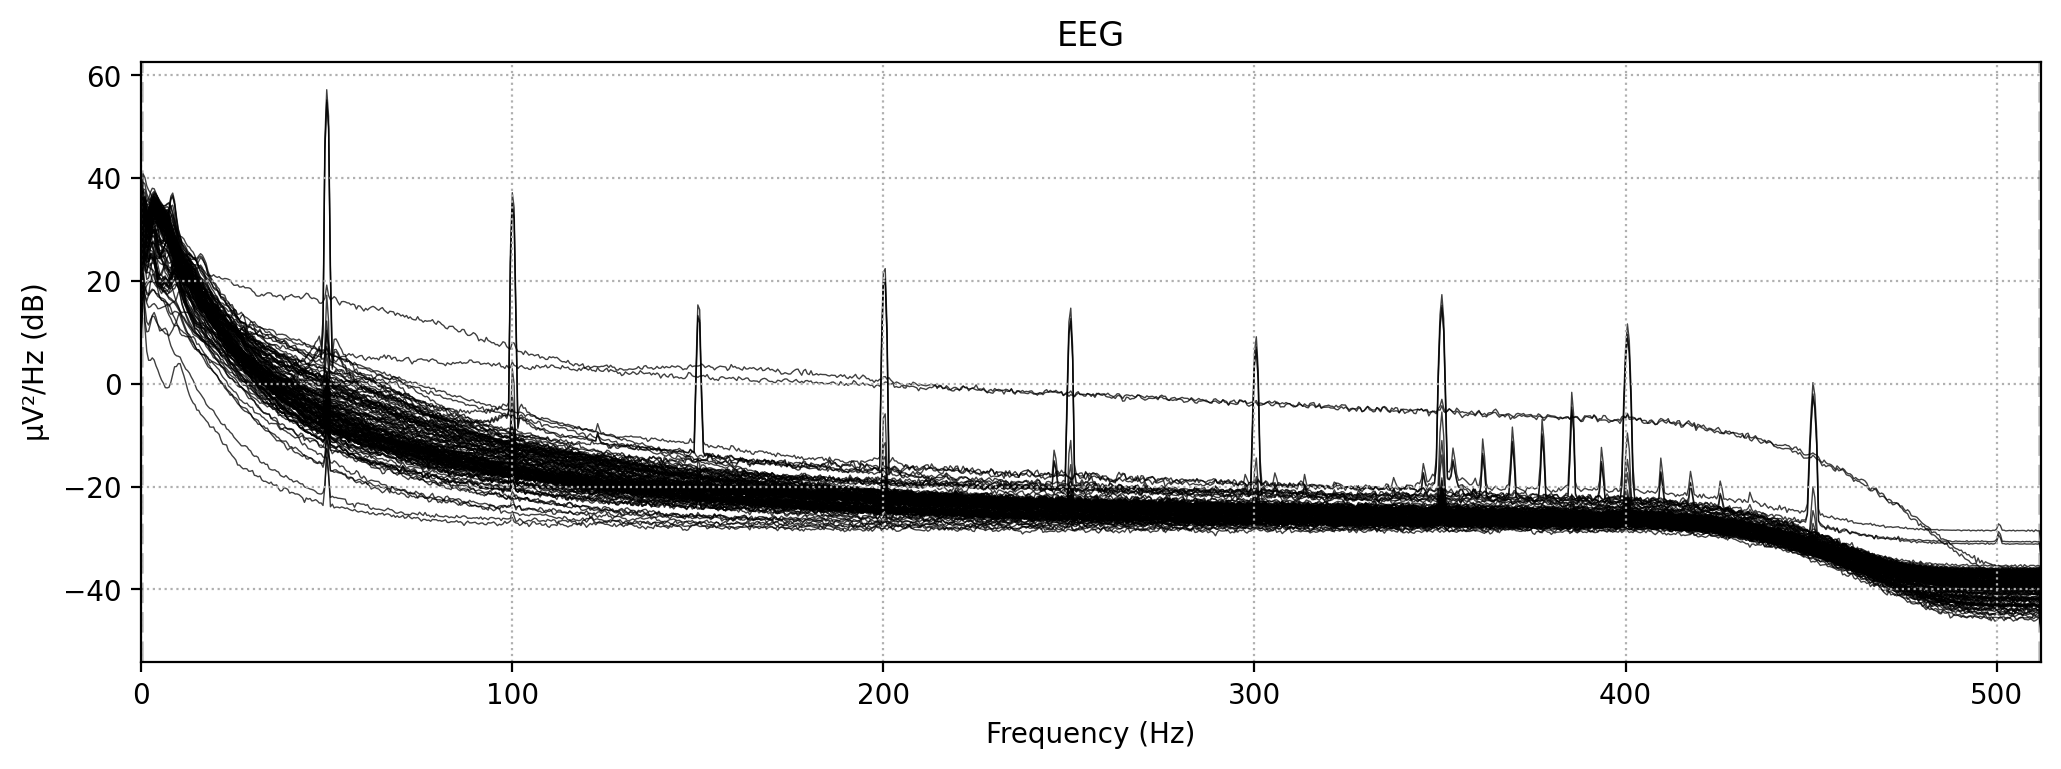

In [14]:
raw.plot_psd(tmin=0, tmax=600, average=False, exclude="bads")  # zoom in will see these high picks all come from three channels: ['Ox-10','TB-9','HP-6']

In [6]:
# line noise
freqs = (50, 100, 150, 200, 250, 300, 350, 400, 450)
raw.notch_filter(freqs=freqs)
# possible low frequency drift
cutoff = 0.1
raw.filter(l_freq=cutoff, h_freq=None)

<RawEDF | EEG.edf, 138 x 4353024 (4251.0 s), ~4.48 GB, data loaded>

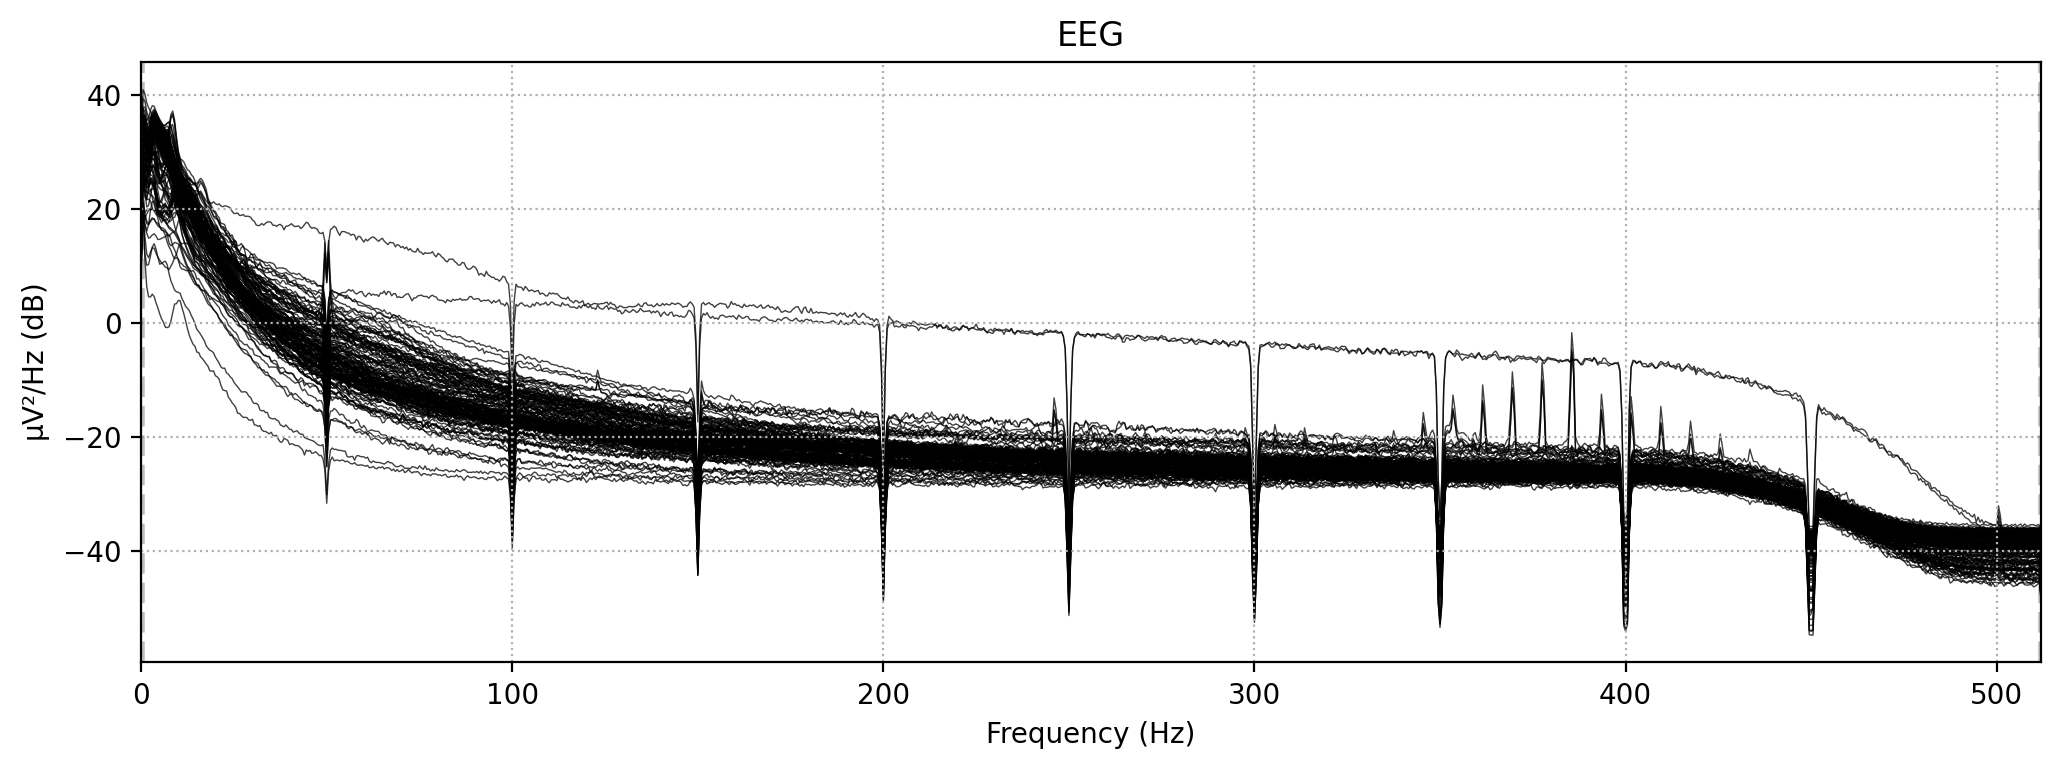

In [16]:
raw.plot_psd(tmin=0, tmax=600, average=False, exclude="bads") # plot again. Line noise of ['Ox-10','TB-9','HP-6'] is fixed, but still there are two bad lines laying way above the others: [['ECG1','ECG2']]

In [7]:
raw.drop_channels(['Ox-10','TB-9','HP-6'])  # todo: no need to drop these three: the line noise has been fixed for these three channels.
raw.drop_channels(['ECG1','ECG2'])

<RawEDF | EEG.edf, 133 x 4353024 (4251.0 s), ~4.31 GB, data loaded>

### working with triggers

In [8]:
plot_scale=100e-5
plot_channels=5
#raw.plot(duration=100,time_format='clock',n_channels=plot_channels, scalings=dict(eeg=50e-5))


In [9]:
##  extract annotations='TRIG[001]:1'
anno_natus=raw.annotations # annotations come from existing trigger info
if type=='ECoG':
    event_descripion='Patient Event'
else:
    event_descripion = 'TRIG[001]:1'

In [10]:
anno_natus[1]

OrderedDict([('onset', 5.515625),
             ('duration', 0.0),
             ('description', 'TRIG[001]:1'),
             ('orig_time',
              datetime.datetime(2023, 11, 17, 9, 51, 34, tzinfo=datetime.timezone.utc))])

### some annotation is not task-related, such as those marked by the nurse.

![](img2.png)

In [11]:
# keep only these trigger with description of 'TRIG[001]:1'.
anno_natus=keep_annotation(anno_natus,event_descripion)
raw.set_annotations(anno_natus)

<RawEDF | EEG.edf, 133 x 4353024 (4251.0 s), ~4.31 GB, data loaded>

In [31]:
# plot it for visual checking: now triggers with other colors are removed
raw.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5))

![](img3.png)

### Read trigger info from matlab
1, export prompts to inf.txt from matlab using export_logfile_to_text.m file;
2, (Fixed in version 2) Manually add time stamp to 'Resumeing' event. The time of resuming is the same as that of next sentence;
2.5, Save the file;
3, Read inf.txt, and format it to lines in the form of "time, sentence";

In [12]:
filename=data_dir+'raw/'+type+str(sid)+'_*/matlab/inf.txt'
filename=os.path.normpath(glob.glob(filename)[0])
#filename=r'D:\data\speech_Southmead\raw\SEEG1\matlab\inf.txt'
with open(filename,"r") as infile:
    lines_tmp=infile.read().split('\n')
prompts_tmp=[tmpi for tmpi in lines_tmp if len(tmpi)>0]

In [13]:
prompts_tmp

['17-Nov-2023 10:12:16',
 'A cheap tattoo can be obscene.',
 '17-Nov-2023 10:12:32',
 'The sea is teal, not blue or green.',
 '17-Nov-2023 10:12:47',
 'The waxing moon will beam in June.',
 '17-Nov-2023 10:13:02',
 'At noon when we will do Tai Chi.',
 '17-Nov-2023 10:13:17',
 'A group of geese attacked the brat.',
 '17-Nov-2023 10:13:32',
 'The actor sued the camera crew.',
 '17-Nov-2023 10:13:47',
 'The hooves on moose are flat and black.',
 '17-Nov-2023 10:14:02',
 'A tea is brewed with leaves or bags.',
 '17-Nov-2023 10:14:18',
 'A lack of shoes to pad my feet.',
 '17-Nov-2023 10:14:33',
 'I plan my meetings back-to-back.',
 '17-Nov-2023 10:14:48',
 'The steel tycoons will flash their cash.',
 '17-Nov-2023 10:15:03',
 'We scan the beach for scraps of trash.',
 '17-Nov-2023 10:15:18',
 'The bluebird preens its beak and back.',
 '17-Nov-2023 10:15:33',
 'A sleuth will handle tampered clues.',
 '17-Nov-2023 10:15:48',
 'To clean your teeth; remove the plaque.',
 '17-Nov-2023 10:16:04',

In [14]:
# format to lines of the form "time, sentence";
prompts=[] # 106
for i in range(int(len(prompts_tmp)/2)):
    tmp=[]
    tmp.append(prompts_tmp[i*2])
    tmp.append(prompts_tmp[i*2+1])
    prompts.append(tmp)

In [15]:
## create matlab annotation from the prompts : append(onset, duration, description, ch_names=None)
import datetime
calendar_dict={month: index for index, month in enumerate(calendar.month_abbr) if month}
orig_time=anno_natus[0]['orig_time']#datetime.datetime(2023, 11, 17, 9, 51, 34, tzinfo=datetime.timezone.utc)
onsets=[]
durations=[]
descriptions=[]
for prompt in prompts:
    time=prompt[0]
    year=int(time.split(' ')[0].split('-')[-1])
    month_tmp = time.split(' ')[0].split('-')[1]
    month=calendar_dict[month_tmp]
    day = int(time.split(' ')[0].split('-')[0])
    hour = int(time.split(' ')[1].split(':')[0])
    min = int(time.split(' ')[1].split(':')[1])
    sec = int(time.split(' ')[1].split(':')[2])
    ts=datetime.datetime(year, month, day, hour, min, sec, tzinfo=datetime.timezone.utc)

    onset=(ts-orig_time).total_seconds()
    onsets.append(onset)
    durations.append(0)
    if prompt[1]=='Pausing':
        descriptions.append('pause')
    elif prompt[1]=='Resuming':
        descriptions.append('resume')
    elif prompt[1]=='Escape':
        descriptions.append('escape')
    else:
        descriptions.append('TRIG-matlab')
anno_matlab=mne.Annotations(onset=onsets,duration=durations,description=descriptions,orig_time=orig_time)# 106=102triggers+4pauses

In [16]:
## combine annotation from natus and matlab
ann_comb=anno_natus.__add__(anno_matlab)
raw1=raw.copy()
raw1.set_annotations(ann_comb)

<RawEDF | EEG.edf, 133 x 4353024 (4251.0 s), ~4.31 GB, data loaded>

In [55]:
# check annotations of both natus and matlab
raw1.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5))

## visually compare triggers from Natus and matlab;

### Add two annotations (program_start, program_end in annotation mode).

Method 1: using GUI:

1,Press 'a' enter annotation mode; 

2, type program_start, then hit enter; 

3, click and drag will create program_start point;

4, type program_end, then hit enter; 

5, click and drag will create program_end point;)

The raw1.annotation will reflect the modified annotation in real-time
(no need to close the figure);

In [53]:
raw1.plot(duration=100,n_channels=plot_channels,scalings=dict(eeg=50e-5)) # put the program_start before the first TRIG[001]:1 (waiting for pressing space bar to start the paradigm), as indicated by the green line below.

![](img4.png)

### Or, add these two annotations by constructing the annotations objects using time and duration, like below:

In [17]:
onsets = [1171, 3656]  # s
durations = [5, 5]  # s
descriptions = ['program_start', 'program_end']
anno_start_end = mne.Annotations(onset=onsets, duration=durations, description=descriptions, orig_time=orig_time)
ann_comb = ann_comb.__add__(anno_start_end)
raw1.set_annotations(ann_comb)

<RawEDF | EEG.edf, 133 x 4353024 (4251.0 s), ~4.31 GB, data loaded>

In [18]:
## extract the experimental data by only keeping program_start and program_end triggers;
seg_anno=raw1.annotations.copy()
seg_anno=keep_annotation(seg_anno, ['program_start','program_end'])
# get start time from 'program_start' trigger
tmin=seg_anno[0]['onset']-5 # extra 5 seconds
tmax=seg_anno[1]['onset']+seg_anno[1]['duration']+5 # extra 5 seconds


In [19]:
tmax

3666.0

In [20]:
raw1.crop(tmin=tmin,tmax=tmax)

<RawEDF | EEG.edf, 133 x 2560001 (2500.0 s), ~2.54 GB, data loaded>

In [21]:
## SEEG1,SEEG2: replace the first 'TRIG[001]:1' with 'keyboard_wait'
# trigger sequence: 'program_start', 'TRIG[001]:1 (should be keyboard_wait)',.....,'program_end';
anno_tmp=raw1.annotations.copy()
replace_anno=mne.Annotations(onset=anno_tmp[1]['onset'],duration=anno_tmp[1]['duration'],description='keyboard_wait',orig_time=anno_tmp[1]['orig_time'])
anno_tmp.delete(1) # the second trigger('program_start', 'TRIG[001]:1',.....,'program_end')
ann_comb2=anno_tmp+replace_anno
raw1.set_annotations(ann_comb2)

<RawEDF | EEG.edf, 133 x 2560001 (2500.0 s), ~2.54 GB, data loaded>

In [22]:
# check again
raw1.plot(duration=100,time_format='float',n_channels=plot_channels,scalings=dict(eeg=50e-5))

###  deal with the missing natus triggers, for example:

![](img5.png)

In [23]:
n_natus=[tmp for tmp in raw1.annotations if tmp['description']=='TRIG[001]:1' ]
n_matlab=[tmp for tmp in raw1.annotations if tmp['description']=='TRIG-matlab' ]
diff=len(n_matlab)-len(n_natus) # 4 triggers missing in n_natus

In [24]:
# First, estimate the time difference between triggers
raw1.annotations[20]['onset']-raw1.annotations[18]['onset'] # 15.25/15.125/15.11/15.13/15.125/15.127/15.132/15.135/15.132/

15.131836000000021

In [25]:
trigger_diff=15.125

### indicate the time range of missing triggers

In [26]:
missings = [[311, 326], [744, 758], [775, 788], [1219, 1236]]
insert = []
for m in missings:
    for n in n_natus:
        if m[0] + tmin < n['onset'] + 15 < m[1] + tmin:
            insert.append(n['onset'] + trigger_diff)  # s

In [27]:
onsets=[]
durations=[]
descriptions=[]
for i in insert:
    onsets.append(i)
    durations.append(0)
    descriptions.append('TRIG[001]:1:inserted')
anno_missing=mne.Annotations(onset=onsets,duration=durations,description=descriptions,orig_time=orig_time)# 106=102triggers+4pauses
ann_comb2_added=ann_comb2.__add__(anno_missing)
raw1.set_annotations(ann_comb2_added)

<RawEDF | EEG.edf, 133 x 2560001 (2500.0 s), ~2.54 GB, data loaded>

In [28]:
len(ann_comb2_added)

211

missing triggers were added, as in below two green lines: (blue ones: matlab triggers; orange ones: natus triggers; green： missing ones)

![](img6.png)

### In GUI, delete trials (may not be completed by the patients) right before 'pause' in annotation mode: press 'a' and enter the annotation mode, check the TRIG-matlab annotation and select the annotation line, then right-click; do the same for 'TRIG[001]:1'/'TRIG[001]:1:inserted'

4 annotations were deleted.

In [32]:
raw1.plot(duration=100,time_format='float',n_channels=plot_channels,scalings=dict(eeg=50e-5))

In [35]:
ann_comb2_added=raw1.annotations

In [36]:
len(ann_comb2_added)

207

In [37]:
## delete 'program_start'+'keyboard_wait'+'pause'+'resume'+'program_end'
ann_comb2_added=delete_annotation(ann_comb2_added,['program_start','keyboard_wait','pause','resume','program_end'])
raw1.set_annotations(ann_comb2_added)

<RawEDF | EEG.edf, 133 x 2560001 (2500.0 s), ~2.54 GB, data loaded>

In [38]:
len(ann_comb2_added)

200

In [39]:
## delete 'TRIG-matlab', keep 'TRIG[001]:1'/'TRIG[001]:1:inserted' only
ann_natus_added=delete_annotation(ann_comb2_added,'TRIG-matlab')
raw1.set_annotations(ann_natus_added)

<RawEDF | EEG.edf, 133 x 2560001 (2500.0 s), ~2.54 GB, data loaded>

In [40]:
## epoch: 15 seconds after trigger
all_events, all_event_id = mne.events_from_annotations(raw1)
epochs = mne.Epochs(raw1, all_events, tmin=0, tmax=15,baseline=None)

In [41]:
## sentence,delete 'Pausing' and 'Resuming'
prompts2=[]
for p in range(len(prompts)):
    if prompts[p][1] not in ['Pausing','Resuming']:
        if p<=len(prompts)-2 and prompts[p+1][1]!='Pausing': # A pause will repeat the previous unfinished sentence.
            prompts2.append(prompts[p][1])
        if p == len(prompts) - 1 and prompts[p][1]!='Pausing':
            prompts2.append(prompts[p][1])

In [42]:
len(epochs.events)==len(prompts2) # must be equal

True

### save everything: epoch and sentences

In [45]:
filename=data_dir+'processed/'+type+str(sid)+'/SEEG'+str(sid)+'-epo.fif'
epochs.save(filename, overwrite=True)
sentences=np.array(prompts2, dtype=object)
filename2=data_dir+'processed/'+type+str(sid)+'/sentences.npy'
np.save(filename2,sentences)
#sentences2=np.load(filename2,allow_pickle=True)
